### Notebook to genereate time-pressure series from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
September 2022

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# from matplotlib import ticker, cm
import sys
import subprocess
from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
from mask_tc_track import mask_tc_track

#### Settings

In [2]:
# #### Variable selection

# Fill variable
iplot = 'vmf'
# options: vmf, thv, the, qrad

# Calculate anomaly as deviation from xy-mean
do_prm_xy = 0

# Should be off for VMF
if iplot == 'vmf':
  do_prm_xy=0

# Strat/Conv index subset
istrat=-1 # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
if istrat == -1:
  fig_extra=''
elif istrat == 0:
  fig_extra='_nonrain'
elif istrat == 1:
  fig_extra='_conv'
elif istrat == 2:
  fig_extra='_strat'
#fig_extra=''

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (deg) limit to keep unmasked

# #### Test/storm selection
storm = 'haiyan'
#storm = 'maria'

# Tests to read and compare
itest = 'ctl'

# Starting member to read
memb='memb_01'

# #### Time selection
nd = 3 # ndays
nt = nd*24
hr_tag = str(np.char.zfill(str(nt), 2))

#### Directories

In [3]:
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"

datdir2 = 'post/d02/'

#### Get dimensions

In [4]:
process = subprocess.Popen(['ls '+main+storm+'/memb_01/ctl/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
lat1d = lat[:,0]
lon1d = lon[0,:]
nx1 = lat1d.size
nx2 = lon1d.size
varfil_main.close()

datdir = main+storm+'/'+memb+'/ctl/'+datdir2
varfil_main = Dataset(datdir+'T.nc')
nz = varfil_main.dimensions['level'].size
pres = varfil_main.variables['pres'][:] # hPa
varfil_main.close()

#### Read variables

In [5]:
if itest == 'ctl':
  t0=36
elif itest == 'ncrf':
  t0=0
elif itest == 'crfon':
  t0=0

t0+=1 # add one time step since NCRF(t=0) = CTL
t1 = t0+nt

print('Running itest: ',itest)

datdir = main+storm+'/'+memb+'/'+itest+'/'+datdir2

# Two-dimensional variables

# Stratiform index
if istrat != -1:
  varfil_main = Dataset(datdir+'strat.nc')
  strat = varfil_main.variables['strat'][t0:t1,:,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
  varfil_main.close()

Running itest:  ctl


In [6]:
# Three-dimensional variables if needed

if iplot == 'thv' or iplot == 'the' or iplot == 'vmf' or iplot == 'rh':
# Mixing ratio
  varfil_main = Dataset(datdir+'QVAPOR.nc')
  qv = varfil_main.variables['QVAPOR'][t0:t1,:,:,:] # kg/kg
  varfil_main.close()
# Temp
  varfil_main = Dataset(datdir+'T.nc')
  tmpk = varfil_main.variables['T'][t0:t1,:,:,:] # K
  varfil_main.close()

In [7]:
# ### Variable selection ##############################################

# if iplot == 'thv':
# # Virtual potential temp
#   var = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
# elif iplot == 'the': 
# # Equiv potential temp
#   var = theta_equiv(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
# elif iplot == 'vmf':
# # Vertical mass flux
#   # Vertical motion
#   varfil = Dataset(datdir+'W.nc') # this opens the netcdf file
#   var = varfil.variables['W'][t0:t1,:,:,:] # m/s
#   varfil.close()
#   # Density
#   # rho = density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3
#   var *= density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3
# elif iplot == 'rh':
# # Humidity
#   var = relh(qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2,tmpk,ice=1) # %
# elif iplot == 'qrad':
# # Radiation
#   varfil = Dataset(datdir+'RTHRATLW.nc') # this opens the netcdf file
#   var = varfil.variables['RTHRATLW'][t0:t1,:,:,:]*3600*24 # K/s --> K/d
#   varfil.close()
#   varfil = Dataset(datdir+'RTHRATSW.nc') # this opens the netcdf file
#   var += varfil.variables['RTHRATSW'][t0:t1,:,:,:]*3600*24 # K/s --> K/d
#   varfil.close()

#### Use track to mask out, then average

In [8]:
def mask_and_avg(var):
    # Localize to TC track
    track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
    var_mask = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)
    
    # Average in x,y
    var_tser = np.mean(var_mask,axis=(2,3))
    
    return var_tser

---
### Plotting routines

In [9]:
# if iplot == 'thv':
#     # Figure settings
#     fig_title=r"$\theta_v$"
#     fig_tag='thv'
#     units_var='K'
#     cmax=5
#     cmin=-1.*cmax
# elif iplot == 'the':
#     # Figure settings
#     fig_title=r"$\theta_e$"
#     fig_tag='the'
#     units_var='K'
#     cmax=5
#     cmin=-1.*cmax
# elif iplot == 'vmf':
#     # Figure settings
#     fig_title='VMF'
#     fig_tag='vmf'
#     units_var='kg m$^{-2}$ s$^{-1}$'
#     cmax=20
#     cmin=-1.*cmax
# elif iplot == 'rh':
#     # Figure settings
#     fig_title='RH'
#     fig_tag='rh'
#     units_var='-'
#     cmax=100
#     cmin=40
# elif iplot == 'qrad':
#     # Figure settings
#     fig_title='$Q_R$'
#     fig_tag='qrad'
#     units_var='K d$^{-1}$'
#     cmax=5
#     cmin=-1.*cmax

# if do_prm_xy == 1:
#     fig_tag+='_xyp'
#     fig_title+=' (xp)'

In [10]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

#### Vertical mass flux

In [11]:
# Vertical mass flux
# Vertical motion
varfil = Dataset(datdir+'W.nc') # this opens the netcdf file
var = varfil.variables['W'][t0:t1,:,:,:] # m/s
varfil.close()
# Density
var *= density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3
var_tser = mask_and_avg(var)

In [12]:
# Figure settings
fig_title='VMF'
fig_tag='vmf'
units_var='kg m$^{-2}$ s$^{-1}$'
cmax=20
cmin=-1.*cmax

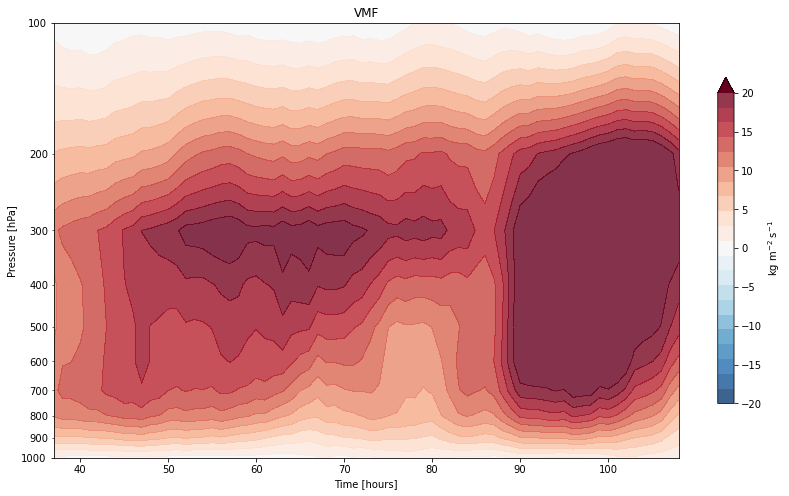

In [13]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Time [hours]')

pltvar = var_tser*1e3

# fill contour
nlevs=21
inc=(cmax-cmin)/nlevs
clevs = np.arange(cmin, cmax+inc, inc)
im = ax.contourf(range(t0,t1), pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.8, \
                 extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=matplotlib.ticker.AutoLocator())
cbar.ax.set_ylabel(units_var)
ax.invert_yaxis()
ax.set_yscale('log')
# ax.set_xscale(log_x)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

# # line contour
# # clevs = np.arange(lcmin, lcmax, lcint)
# clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
# clevs = np.concatenate((-1*np.flip(clevs),clevs))
# cpltvar=binvar_c_mn
# im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
# ax.clabel(im, im.levels, inline=True, fontsize=13)

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

#### Relative humidity

In [14]:
# Rel hum
var = relh(qv,pres[np.newaxis,:,np.newaxis,np.newaxis]*1e2,tmpk,ice=1) # %
# var_tser = mask_and_avg(var)

In [ ]:
var_tser = mask_and_avg(var)

In [15]:
# Figure settings
fig_title='RH'
fig_tag='rh'
units_var='%'
cmax=100
cmin=40

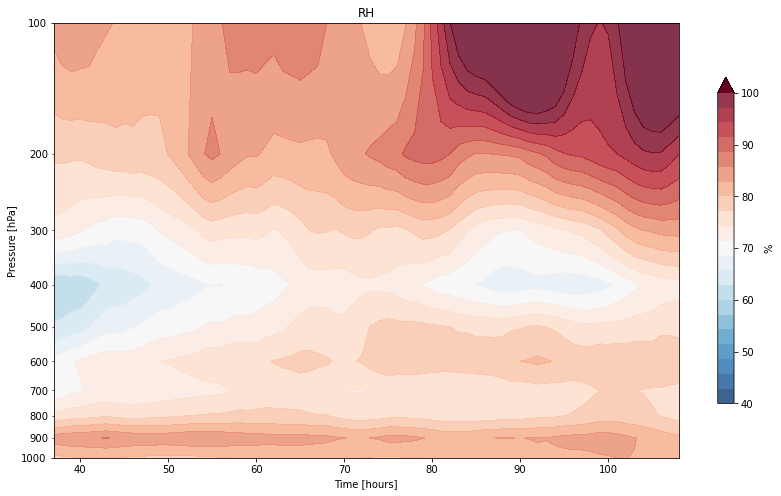

In [18]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Time [hours]')

pltvar = var_tser

# fill contour
nlevs=21
inc=(cmax-cmin)/nlevs
clevs = np.arange(cmin, cmax+inc, inc)
im = ax.contourf(range(t0,t1), pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.8, \
                 extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=matplotlib.ticker.AutoLocator())
cbar.ax.set_ylabel(units_var)
ax.invert_yaxis()
ax.set_yscale('log')
# ax.set_xscale(log_x)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

# # line contour
# # clevs = np.arange(lcmin, lcmax, lcint)
# clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
# clevs = np.concatenate((-1*np.flip(clevs),clevs))
# cpltvar=binvar_c_mn
# im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
# ax.clabel(im, im.levels, inline=True, fontsize=13)

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)